## 4) Polarity analysis on Amazon Fine Food Reviews dataset using Naive_bayes

In [67]:
import numpy as np
import seaborn as sns
import sqlite3
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from time import time
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from prettytable import PrettyTable

 Preprocessing of data has been done on the Dataset and stored it in the Final.sqlite.<br>
 Preprocessing included the following operations:<br>
    i) Begin by removing the html tags<br>
    ii) Remove any punctuations or limited set of special characters like , or . or # etc.<br>
    iii) Check if the word is made up of english letters and is not alpha-numeric<br>
    iv) Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)<br>
    v) Convert the word to lowercase<br>
    vi) Remove stopwords<br>
    vii) Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

In [2]:
con=sqlite3.connect("final.sqlite")
reviews=pd.read_sql_query("select *from Reviews",con)
reviews.drop("index",axis=1,inplace=True)
reviews.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,Positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...


In [3]:

score_count=reviews["Score"].values

In [4]:
neg=0
pos=0
for i in range(len(score_count)-1):
    if score_count[i]=="Positive":
        pos+=1
    else:
        neg+=1
print(pos,neg)


307028 57108


Unbalanced dataset

In [5]:
#soritng based on time and splitting into test and train
reviews.sort_values("Time",inplace=True)
X_train,X_test,Y_train,Y_test=train_test_split(reviews["CleanedText"].values,reviews["Score"].values,test_size=0.3,random_state=0,shuffle=False)

In [6]:
print(X_train.shape)
print(X_test.shape)

(254895,)
(109242,)


In [7]:
#drawing confusion matrix..and returning it
def drawConfusionMatrix(Y_test,pred):
    conf_matrix=confusion_matrix(Y_test,pred)
    heatmap_conf=sns.heatmap(conf_matrix,annot=True,fmt="d")
    return conf_matrix

### 1) Bag of words Vectorization

In [9]:
bow_vect=CountVectorizer()
train_vect=bow_vect.fit_transform(X_train)
test_vect=bow_vect.transform(X_test)

In [10]:
print(train_vect.shape)
print(test_vect.shape)

(254895, 59189)
(109242, 59189)


In [11]:
tscv=TimeSeriesSplit(n_splits=5)
params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10]}
clf=GridSearchCV(MultinomialNB(),params,cv=tscv)
gs_classifier=clf.fit(train_vect,Y_train)
optimal_alpha_bow=clf.best_estimator_.alpha

In [89]:
acc=clf.best_score_*100
print("The optimal Alpha Value is {0:.4f} with accuracy of {1:.3f}%".format(optimal_alpha_bow,acc))

The optimal Alpha Value is 1.0000 with accuracy of 89.647%


In [90]:
test_score=clf.score(test_vect,Y_test)
print("The testing acc for this model with Alpha ={0:.4f} is {1:.3f}%".format(optimal_alpha_bow,test_score*100))

The testing acc for this model with Alpha =1.0000 is 91.337%


In [91]:
#to get missclassification error
mean_test_scores=clf.cv_results_['mean_test_score']
mis_classif=[1-i for i in mean_test_scores]
print(mis_classif)

[0.11560190198201592, 0.11425544936679066, 0.11271597382420795, 0.11136952120898258, 0.10863895296831594, 0.1035309072077586, 0.14540275881549836]


In [15]:
alphas=clf.cv_results_['param_alpha']
alphas=np.array(alphas)

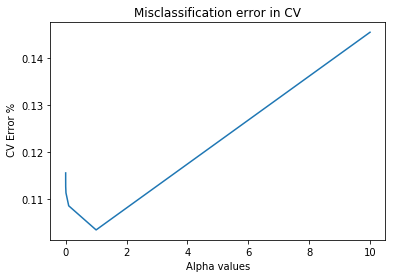

In [33]:
plt.plot(alphas,mis_classif)
plt.ylabel(" CV Error %")
plt.xlabel("Alpha values")
plt.title("Misclassification error in CV")
plt.show()

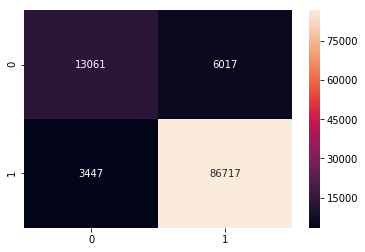

In [85]:
#testing the model with bag of words representation
classif=clf.best_estimator_.fit(test_vect,Y_test)
pred=classif.predict(test_vect)
conf_matrix=drawConfusionMatrix(Y_test,pred)

In [102]:
#Model metrics like precision,recall and f1_score
print(classification_report(Y_test,pred))

             precision    recall  f1-score   support

   Negative       0.79      0.68      0.73     19078
   Positive       0.94      0.96      0.95     90164

avg / total       0.91      0.91      0.91    109242



In [123]:
#most important features of a class lable with wordCloud
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.best_estimator_.feature_log_prob_[labelid], feature_names))[-n:]
    features=''
    for count, feat in topn:
        features=features+feat+' '
    wordcloud = WordCloud(width = 1000, height = 600, 
                background_color ='white',  
                min_font_size = 10).generate(features) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()

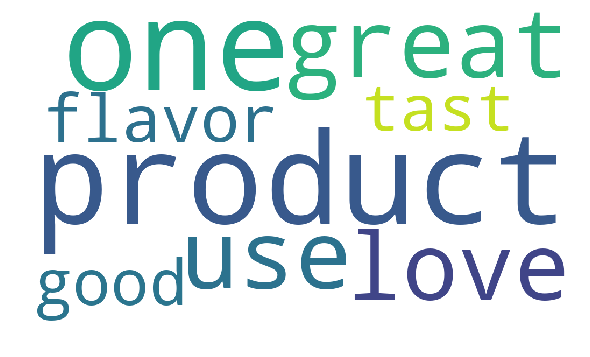

In [124]:
#most informative features for positive class
most_informative_feature_for_class(bow_vect,clf,"Positive",n=10)

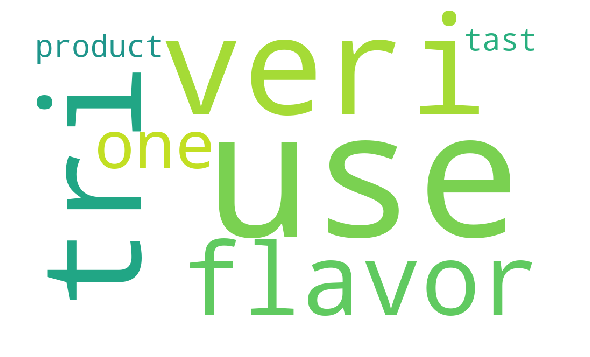

In [125]:
#most informative features for negative class
neg_feats=most_informative_feature_for_class(bow_vect,clf,"Negative",n=10)


### 2) TF_IDF Vectorization 

In [28]:
tfidf_vect=TfidfVectorizer(ngram_range=(1,2))
train_idf=tfidf_vect.fit_transform(X_train)
test_idf=tfidf_vect.transform(X_test)

In [74]:
tscv=TimeSeriesSplit(n_splits=5)
params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10]}
clf_idf=GridSearchCV(MultinomialNB(),params,cv=tscv)
clf_idf.fit(train_idf,Y_train)
optimal_alpha=clf_idf.best_estimator_.alpha
acc=clf_idf.best_score_*100
print("The optimal Alpha Value is {0:.4f} with accuracy of {1:.3f}%".format(optimal_alpha,acc))

The optimal Alpha Value is 0.0100 with accuracy of 88.959%


In [79]:
clf_idf.best_estimator_

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [75]:
test_score=clf_idf.score(test_idf,Y_test)
print("The testing acc for this model with Alpha ={0:.4f} is {1:.3f}%".format(optimal_alpha,test_score*100))

The testing acc for this model with Alpha =0.0100 is 89.682%


In [76]:
mean_test_scores=clf_idf.cv_results_['mean_test_score']
mis_classif=[1-i for i in mean_test_scores]
print(mis_classif)

[0.12542723977213877, 0.11728261381290894, 0.11059272162327571, 0.11041382232474928, 0.13284685278470887, 0.1569747187043925, 0.1569982580857775]


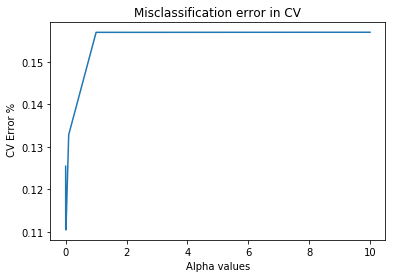

In [77]:
alphas=clf_idf.cv_results_['param_alpha']
alphas=np.array(alphas)
plt.plot(alphas,mis_classif)
plt.ylabel(" CV Error %")
plt.xlabel("Alpha values")
plt.title("Misclassification error in CV")
plt.show()

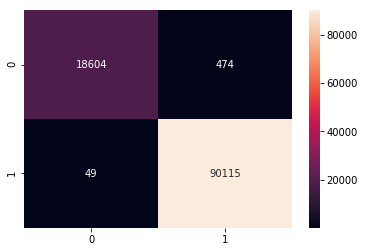

In [84]:
classif=clf_idf.best_estimator_.fit(test_idf,Y_test)
pred_tfidf=classif.predict(test_idf)
conf_matrix_idf=drawConfusionMatrix(Y_test,pred_tfidf)

In [94]:
#TFIDF representation Naive bayes model metrics
print(classification_report(Y_test,pred_tfidf))

             precision    recall  f1-score   support

   Negative       1.00      0.98      0.99     19078
   Positive       0.99      1.00      1.00     90164

avg / total       1.00      1.00      1.00    109242



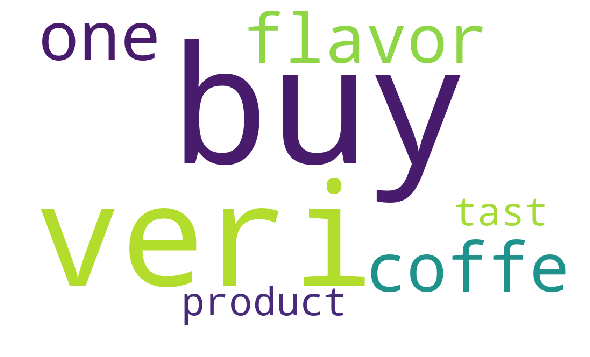

In [126]:
#most informative features for negative class
most_informative_feature_for_class(tfidf_vect,clf_idf,"Negative",n=10)

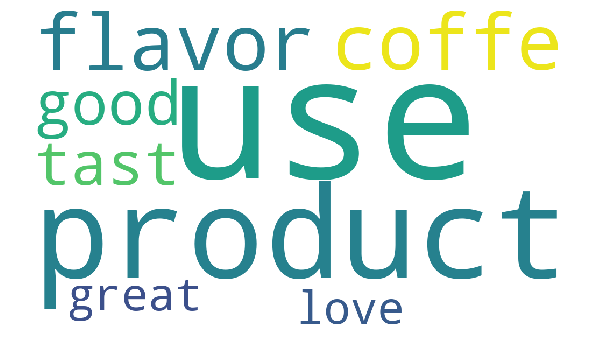

In [127]:
#most informative features for positive class
most_informative_feature_for_class(tfidf_vect,clf_idf,"Positive",n=10)

In [129]:
t=PrettyTable(['Model','Vectorizer','Hyper param','train_error','test_error'])
t.add_row(["MultinomialNB","TFIDF",'0.1','10.36%','8.77%'])
t.add_row(["MultinomialNB","BOW",'1.0','11.04%','10.32%'])
print(t)

+---------------+------------+-------------+-------------+------------+
|     Model     | Vectorizer | Hyper param | train_error | test_error |
+---------------+------------+-------------+-------------+------------+
| MultinomialNB |   TFIDF    |     0.1     |    10.36%   |   8.77%    |
| MultinomialNB |    BOW     |     1.0     |    11.04%   |   10.32%   |
+---------------+------------+-------------+-------------+------------+


## Conclusions

#### BOW Vectorization<br>
1) Compare to K-NN model Naive Bayes model is significantly faster.<br>
2) Using BOW our model's optimal alpha found to be '1' with Train acc of 89%, and test acc 91% these too are close hence our model performed better on test data(unseen data).<br>
3) As data is not balanced we have taken the Presicion, recall and F1 score metrics.<br>
4) BOW F1 score for Negative class is low which tells us misclassification for Negative class is more.<br>

#### TF-IDF Vectorization<br>

1) When TF-IDF used our model performed exceptionally good with an F1 score of '0.99' and '1.0' for Negative and Positive classes respectively.<br>
2) Optimal alpha value is 0.01 with train accuracy of 88.95%.<br>
3) Only 49 out of 90k positive labels are misclassified.<br>
4) Unlike BOW Negative label misclassification is very less for TF_IDF.<br>
5) TF_IDF is better vectorization to select for this model.<br>